<a href="https://colab.research.google.com/github/Chaotic-Legend/CMP-333-Codes/blob/main/Final%20Project%3A%20Data%20Dashboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Data Dashboard Creation With Python

In this project assignment, you will have the opportunity to demonstrate your data visualization and dashboard creation skills using Python. You will be tasked with collecting, cleaning, and visualizing data to create a data dashboard that provides insights into a specific dataset of your choice.

**Collect Data**: Choose a dataset that interests you and is relevant to your choice of industry. You may browse for available datasets on [Kaggle](http://kaggle.com/datasets) or [NYC Open Data](https://opendata.cityofnewyork.us/data/). Make sure that the dataset is in a format that can be easily processed in Python (e.g., CSV, Excel, or JSON).

**Data Preprocessing**: Clean and preprocess the dataset as needed. Make sure to handle missing values, data type conversions, and any other necessary data transformations.

**Descriptive Statistics**: Calculate and include descriptive statistics for key variables in your dataset. This should include measures such as mean, median, mode, standard deviation, and percentiles. Present these statistics in a clear and organized manner in your dashboard.

**Data Visualization**: Use Python libraries such as Matplotlib, Seaborn, and Plotly to create meaningful visualizations from your dataset. You should aim to create at least three different types of visualizations (e.g., bar charts, line plots, scatter plots, etc.) to represent various aspects of the data.

**Dashboard Creation**: Create a single-slide PowerPoint or Google Slides presentation that acts as your data dashboard. The dashboard should include the source of the dataset, visualizations, descriptive statistics, and key insights.

**Submission**: Submit the data dashboard and the notebook file that create visualizations and analysis to BrightSpace.

**Grading Criteria**: Your project will be assessed based on the following criteria:

- Data Collection and Preprocessing (15%)

- Calculation of Descriptive Statistics (15%)

- Data Visualization (15%)

- Dashboard Creation (40%)

- Insights and Analysis (15%)

#### CMP 333: Data Management and Analysis - Isaac D. Hoyos

# Final Project: Dataset Reference
#### **Dataset Name**: Motor Vehicle Collisions – Crashes

#### **Source**: NYC Open Data (New York City Police Department)

#### **Description**: This dataset contains records of reported motor vehicle collisions in New York City, including information on date, time, location, injuries, fatalities, and contributing factors.

#### **Dataset URL**: https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95

The borough value "UNKNOWN" appears most frequently because many collision records lack sufficient or complete location information to determine a borough. This reflects limitations in data collection rather than the actual geographic distribution of collisions, but to preserve data completeness, missing borough values were standardized as "UNKNOWN" during preprocessing. For the interpretive analysis, summary statistics were calculated, both including and excluding "UNKNOWN," to differentiate between data quality effects and meaningful geographic trends, and to determine the most common actual borough.

In [1]:
# Import core and visualization libraries used throughout the project.
import os
import math
import time
import zipfile
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Inform the user that setup may take some time due to required installations.
print("⚠️ Please allow some time for the required installations to complete before running this project.")
print("🔄 You may need to restart the session for the installations to take effect when running this project.\n")
time.sleep(5)

# Install system dependencies required by Kaleido for static image export.
!sudo apt update && sudo apt-get install -y libnss3 libatk-bridge2.0-0 libcups2 libxcomposite1 libxdamage1 libxfixes3 libxrandr2 libgbm1 libxkbcommon0 libpango-1.0-0 libcairo2 libasound2

# Install Python libraries needed for data analysis, visualization, and PowerPoint creation.
!pip install pandas numpy matplotlib seaborn python-pptx kaleido
!pip install -U plotly

# Import utility libraries used for progress tracking, data loading, and presentation output.
from tqdm import tqdm
from io import StringIO
from pptx import Presentation
from google.colab import files
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from collections import Counter
from IPython.display import display
print("\n✅ All installations are complete, and the environment is now ready to run this project!")

⚠️ Please allow some time for the required installations to complete before running this project.
🔄 You may need to restart the session for the installations to take effect when running this project.

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Reading package lists... Done
Bu

In [2]:
# Set a consistent visual style for charts throughout the notebook.
sns.set(style="whitegrid", rc={"figure.figsize": (10, 6)})

# Define the dataset URL used to download the NYC Open Data CSV file.
CSV_URL = "https://data.cityofnewyork.us/resource/h9gi-nx95.csv?$limit=50000"

# Define the local filename for saving the dataset in the Colab environment.
LOCAL_CSV_FILENAME = "Motor Vehicle Collisions - Crashes.csv"

# Check whether the CSV file already exists in the environment.
if os.path.exists(LOCAL_CSV_FILENAME):
    print(f"📦 Using the downloaded \"{LOCAL_CSV_FILENAME}\" file as the dataset.")
    df = pd.read_csv(LOCAL_CSV_FILENAME, parse_dates=["crash_date"])
else:
    # Download the dataset while displaying a progress bar to the user.
    response = requests.get(CSV_URL, stream=True)
    response.raise_for_status()
    total_size = int(response.headers.get("content-length", 0))
    block_size = 1024

    tqdm_bar = tqdm(
        total=total_size if total_size > 0 else None,
        unit="iB",
        unit_scale=True,
        desc="⬇️ Downloading The NYC Open Data CSV File")

    # This byte container will store the downloaded CSV data.
    csv_data = b""
    for data in response.iter_content(block_size):
        tqdm_bar.update(len(data))
        csv_data += data
    tqdm_bar.close()

    # Save the downloaded CSV file to the Colab working directory.
    with open(LOCAL_CSV_FILENAME, "wb") as f:
        f.write(csv_data)
    print(f"\n☑️ Dataset successfully saved as \"{LOCAL_CSV_FILENAME}\".")

    # Convert the downloaded bytes into a text stream readable by pandas.
    csv_str = StringIO(csv_data.decode("utf-8"))

    # Load the CSV data into a pandas DataFrame and parse the crash_date column as a date.
    df = pd.read_csv(csv_str, parse_dates=["crash_date"])

# Create DataFrames for rows with and without missing borough values.
df_with_nan = df[df["borough"].isna()]
df_without_nan = df[df["borough"].notna()]

# Display high-level dataset information.
print("\n=== Motor Vehicle Collisions – Crashes Dataset Overview ===")
print("📊 Columns:", df.columns.tolist())
print(f"🗄️ Total Number of Rows (Raw Dataset): {len(df)}")
print(f"🗃️ Rows With Missing Borough Values: {len(df_with_nan)}")
print(f"🗂️ Rows With Valid Borough Values: {len(df_without_nan)}")

# Display a preview of rows with missing borough values.
print("\n=== First 5 Rows With Missing Borough Values ===")
display(df_with_nan.head())

# Display a preview of rows with valid borough values.
print("\n=== First 5 Rows With Valid Borough Values ===")
display(df_without_nan.head())

⬇️ Downloading The NYC Open Data CSV File: 12.3MiB [00:06, 1.82MiB/s]



☑️ Dataset successfully saved as "Motor Vehicle Collisions - Crashes.csv".

=== Motor Vehicle Collisions – Crashes Dataset Overview ===
📊 Columns: ['crash_date', 'crash_time', 'borough', 'zip_code', 'latitude', 'longitude', 'location', 'on_street_name', 'off_street_name', 'cross_street_name', 'number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed', 'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2', 'contributing_factor_vehicle_3', 'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5', 'collision_id', 'vehicle_type_code1', 'vehicle_type_code2', 'vehicle_type_code_3', 'vehicle_type_code_4', 'vehicle_type_code_5']
🗄️ Total Number of Rows (Raw Dataset): 50000
🗃️ Rows With Missing Borough Values: 17291
🗂️ Rows With Valid Borough Values: 32709

=== First 5 Rows With Missing Borough Value

,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
0,2021-09-11,2:39,NaN,NaN,NaN,NaN,NaN,WHITESTONE EXPRESSWAY,20 AVENUE,NaN,...,Unspecified,NaN,NaN,NaN,4455765,Sedan,Sedan,NaN,NaN,NaN
1,2022-03-26,11:45,NaN,NaN,NaN,NaN,NaN,QUEENSBORO BRIDGE UPPER,NaN,NaN,...,NaN,NaN,NaN,NaN,4513547,Sedan,NaN,NaN,NaN,NaN
3,2022-06-29,6:55,NaN,NaN,NaN,NaN,NaN,THROGS NECK BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4541903,Sedan,Pick-up Truck,NaN,NaN,NaN
4,2022-09-21,13:21,NaN,NaN,NaN,NaN,NaN,BROOKLYN BRIDGE,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4566131,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
5,2023-04-26,13:30,NaN,NaN,NaN,NaN,NaN,WEST 54 STREET,NaN,NaN,...,Unspecified,NaN,NaN,NaN,4623759,Sedan,Box Truck,NaN,NaN,NaN



=== First 5 Rows With Valid Borough Values ===


,crash_date,crash_time,borough,zip_code,latitude,longitude,location,on_street_name,off_street_name,cross_street_name,...,contributing_factor_vehicle_2,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,collision_id,vehicle_type_code1,vehicle_type_code2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5
2,2023-11-01,1:29,BROOKLYN,11230.0,40.621790,-73.970024,"\n, \n(40.62179, -73.970024)",OCEAN PARKWAY,AVENUE K,NaN,...,Unspecified,Unspecified,NaN,NaN,4675373,Moped,Sedan,Sedan,NaN,NaN
9,2021-09-11,9:35,BROOKLYN,11208.0,40.667202,-73.866500,"\n, \n(40.667202, -73.8665)",NaN,NaN,1211 LORING AVENUE,...,NaN,NaN,NaN,NaN,4456314,Sedan,NaN,NaN,NaN,NaN
10,2021-12-14,8:13,BROOKLYN,11233.0,40.683304,-73.917274,"\n, \n(40.683304, -73.917274)",SARATOGA AVENUE,DECATUR STREET,NaN,...,NaN,NaN,NaN,NaN,4486609,NaN,NaN,NaN,NaN,NaN
13,2021-12-14,8:17,BRONX,10475.0,40.868160,-73.831480,"\n, \n(40.86816, -73.83148)",NaN,NaN,344 BAYCHESTER AVENUE,...,Unspecified,NaN,NaN,NaN,4486660,Sedan,Sedan,NaN,NaN,NaN
14,2021-12-14,21:10,BROOKLYN,11207.0,40.671720,-73.897100,"\n, \n(40.67172, -73.8971)",NaN,NaN,2047 PITKIN AVENUE,...,Unspecified,NaN,NaN,NaN,4487074,Sedan,NaN,NaN,NaN,NaN


In [3]:
# Normalize all column names by stripping whitespace and converting them to lowercase.
df.columns = [c.strip() for c in df.columns]
cols_lower = {c: c.lower() for c in df.columns}
df.rename(columns=cols_lower, inplace=True)

# Convert date and time columns to proper datetime formats when available.
if "crash_date" in df.columns:
    df["crash_date"] = pd.to_datetime(df["crash_date"], errors="coerce")

if "crash_time" in df.columns:
    # Create a combined datetime column using the crash date and the crash time.
    df["crash_datetime"] = pd.to_datetime(
        df["crash_date"].dt.strftime("%m/%d/%Y") + " " + df["crash_time"].astype(str),
        errors="coerce")
else:
    # Fall back to using the crash date alone if no crash time column is present.
    df["crash_datetime"] = df["crash_date"]

# Derive additional time-based features from the crash datetime.
df["year"] = df["crash_datetime"].dt.year
df["month"] = df["crash_datetime"].dt.to_period("M")
df["month_str"] = df["month"].astype(str)
df["hour"] = df["crash_datetime"].dt.hour

# Ensure that key numeric columns exist and are stored as integers.
num_cols = ["number_of_persons_injured", "number_of_persons_killed"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)
    else:
        print(f"⚠️ Warning: The expected column \"{c}\" was not found in the dataset.")

# Clean borough values by standardizing text and filling missing entries.
if "borough" in df.columns:
    df["borough"] = df["borough"].fillna("UNKNOWN").str.upper().str.strip()
else: df["borough"] = "UNKNOWN"

# Remove rows that do not contain a valid crash datetime.
df = df[~df["crash_datetime"].isna()].copy()

# Filter the dataset to include only records from recent years.
df = df[df["year"].between(2015, pd.Timestamp.now().year)]

# Create two clean views of the dataset.
df_with_unknown = df.copy()
df_without_unknown = df[df["borough"] != "UNKNOWN"].copy()

# Print summary messages confirming the cleaning results.
print(f"📃 Total Number of Rows After Cleaning (Including Missing Values): {len(df_with_unknown)}")
print(f"\n📄 Total Number of Rows After Cleaning (Excluding Missing Values): {len(df_without_unknown)}")

📃 Total Number of Rows After Cleaning (Including Missing Values): 49999

📄 Total Number of Rows After Cleaning (Excluding Missing Values): 32708


In [4]:
# Calculate the total number of collisions per month.
monthly_counts = df.groupby("month_str").size().reset_index(name="collisions")
monthly_counts["month_dt"] = pd.to_datetime(monthly_counts["month_str"])
monthly_counts = monthly_counts.sort_values("month_dt")

# Generate descriptive statistics for the number of persons injured.
injury_stats = (
    df["number_of_persons_injured"]
    .describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90])
    .to_frame(name="number_of_persons_injured"))

# Generate descriptive statistics for the number of persons killed.
kill_stats = (
    df["number_of_persons_killed"]
    .describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90])
    .to_frame(name="number_of_persons_killed"))

# Identify the most common borough including UNKNOWN values.
most_common_borough_including_unknown = (
    df["borough"].mode().iloc[0]
    if not df["borough"].mode().empty
    else "UNKNOWN")

# Identify the most common borough excluding UNKNOWN values.
most_common_borough_excluding_unknown = (
    df[df["borough"] != "UNKNOWN"]["borough"].mode().iloc[0]
    if not df[df["borough"] != "UNKNOWN"]["borough"].mode().empty
    else "N/A")

# Display monthly collision data, injury statistics, and fatality statistics.
print("=== 🚗 Monthly Collision Counts (Sample) ===")
display(monthly_counts.head())
print("\n=== 🚑 Injury Statistics Summary ===")
display(injury_stats)
print("\n=== 💀 Fatality Statistics Summary ===")
display(kill_stats)

# Display both borough values for transparency and interpretation.
print(f"\n🏙️ Most Common Borough (Including Missing Values): {most_common_borough_including_unknown}")
print(f"\n📍 Most Common Borough (Excluding Missing Values): {most_common_borough_excluding_unknown}")

=== 🚗 Monthly Collision Counts (Sample) ===


,month_str,collisions,month_dt
0,2016-04,1,2016-04-01
1,2016-06,2,2016-06-01
2,2016-09,1,2016-09-01
3,2019-04,1,2019-04-01
4,2019-05,1,2019-05-01



=== 🚑 Injury Statistics Summary ===


,number_of_persons_injured
count,49999.000000
mean,0.473009
std,0.796249
min,0.000000
10%,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
90%,1.000000
max,18.000000



=== 💀 Fatality Statistics Summary ===


,number_of_persons_killed
count,49999.000000
mean,0.002840
std,0.055786
min,0.000000
10%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000
max,3.000000



🏙️ Most Common Borough (Including Missing Values): UNKNOWN

📍 Most Common Borough (Excluding Missing Values): BROOKLYN


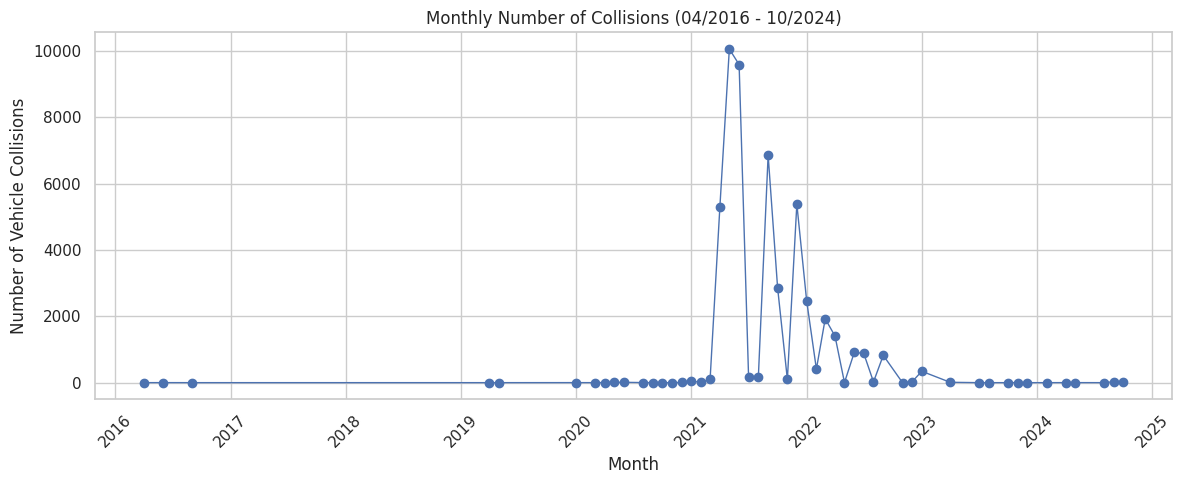


✅ Line Chart successfully saved as "Monthly Vehicle Collisions.png".


In [5]:
# Create a new figure for the monthly collision trend visualization.
plt.figure(figsize=(12, 5))

# Plot the number of collisions per month using a line chart with markers.
plt.plot(
    monthly_counts["month_dt"],
    monthly_counts["collisions"],
    marker="o",
    linewidth=1)

# Set the chart title to include the date range covered by the data.
plt.title(
    "Monthly Number of Collisions ({} - {})".format(
        monthly_counts["month_dt"].min().strftime("%m/%Y"),
        monthly_counts["month_dt"].max().strftime("%m/%Y")))

# Label the x-axis and y-axis, and rotate the x-axis labels for readability.
plt.xlabel("Month")
plt.ylabel("Number of Vehicle Collisions")
plt.xticks(rotation=45)

# Adjust the layout to prevent overlapping labels and elements.
plt.tight_layout()

# Save the figure as a PNG image for later use in the dashboard.
plt.savefig("Monthly Vehicle Collisions.png", dpi=150)

# Display the line graph in the notebook and confirm that the image was saved.
plt.show()
print("\n✅ Line Chart successfully saved as \"Monthly Vehicle Collisions.png\".")

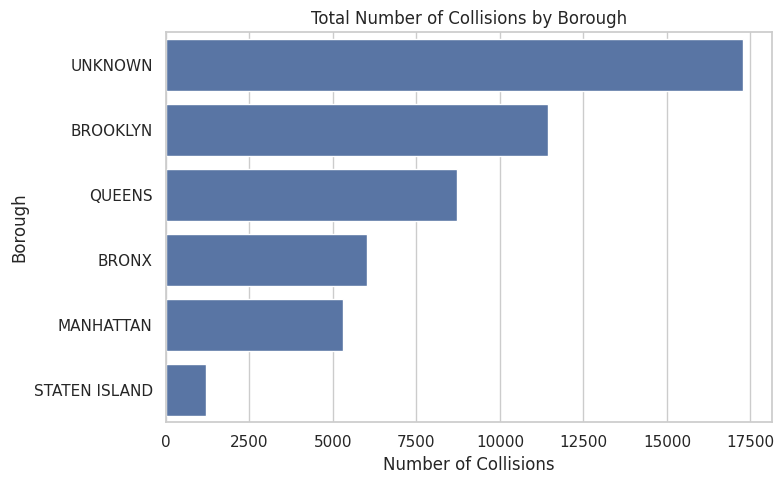


✅ Bar Chart successfully saved as "Borough Collision Counts.png".


In [6]:
# Calculate the total number of collisions for each borough and sort the results in descending order.
borough_counts = (df.groupby("borough")
    .size()
    .reset_index(name="collisions")
    .sort_values("collisions", ascending=False))

# Create a new figure for the borough-level collision bar chart.
plt.figure(figsize=(8, 5))

# Plot the number of collisions by borough using a horizontal bar chart.
sns.barplot(data=borough_counts, x="collisions", y="borough")

# Set the chart title and axis labels, and adjust the layout to prevent overlapping elements.
plt.title("Total Number of Collisions by Borough")
plt.xlabel("Number of Collisions")
plt.ylabel("Borough")
plt.tight_layout()

# Save the figure as a PNG image with a clear and descriptive filename.
plt.savefig("Borough Collision Counts.png", dpi=150)

# Display the bar chart in the notebook and confirm that the image was saved.
plt.show()
print("\n✅ Bar Chart successfully saved as \"Borough Collision Counts.png\".")

In [7]:
import kaleido
kaleido.get_chrome_sync()

# Identify columns related to vehicle involvement if they exist in the dataset.
possible_vehicle_cols = [
    c for c in df.columns if "vehicle" in c and ("involved" in c or "count" in c)]

# Create a random sample of the dataset to improve plotting performance.
fig = None
scatter_df = df.sample(min(2000, len(df)))
if possible_vehicle_cols:
    # Convert the vehicle-related column to numeric values and handle missing data.
    veh_col = possible_vehicle_cols[0]
    df[veh_col] = pd.to_numeric(df[veh_col], errors="coerce").fillna(0).astype(int)

    # Create a scatter plot showing injuries versus the number of vehicles involved.
    fig = px.scatter(
        scatter_df,
        x=veh_col,
        y="number_of_persons_injured",
        hover_data=["borough", "crash_datetime"],
        title="Persons Injured vs. Number of Vehicles Involved (Sample)",
        template="plotly_white")
else:
    # Create a fallback scatter plot showing injuries by hour of the day.
    fig = px.scatter(
        scatter_df,
        x="hour",
        y="number_of_persons_injured",
        hover_data=["borough", "crash_datetime"],
        title="Persons Injured vs. Hour of Day (Sample)",
        template="plotly_white")

# Save the scatter plot as a PNG image with a filename for dashboard use.
plt_filename = "Hourly Injury Patterns.png"
fig.write_image(plt_filename, width=800, height=500)

# Display the scatter plot in the notebook and confirm that the image was saved.
fig.show()
print(f"✅ Scatter Plot successfully saved as \"{plt_filename}\".")

✅ Scatter Plot successfully saved as "Hourly Injury Patterns.png".


In [8]:
# Create a summary table containing key descriptive statistics.
stats_table = pd.DataFrame(
    {
        "metric": [
            "total_collisions",
            "mean_persons_injured",
            "median_persons_injured",
            "std_persons_injured",
            "90th_pct_persons_injured",
            "most_common_borough"],
        "including_UNKNOWN": [
            len(df_with_unknown),
            df_with_unknown["number_of_persons_injured"].mean(),
            df_with_unknown["number_of_persons_injured"].median(),
            df_with_unknown["number_of_persons_injured"].std(),
            np.percentile(
                df_with_unknown["number_of_persons_injured"].dropna(), 90),
            most_common_borough_including_unknown],
        "excluding_UNKNOWN": [
            len(df_without_unknown),
            df_without_unknown["number_of_persons_injured"].mean(),
            df_without_unknown["number_of_persons_injured"].median(),
            df_without_unknown["number_of_persons_injured"].std(),
            np.percentile(
                df_without_unknown["number_of_persons_injured"].dropna(), 90),
            most_common_borough_excluding_unknown]})

# Display the statistics table for inspection and dashboard use.
print("=== Descriptive Statistics Summary ===")
stats_table

=== Descriptive Statistics Summary ===


,metric,including_UNKNOWN,excluding_UNKNOWN
0,total_collisions,49999,32708
1,mean_persons_injured,0.473009,0.443684
2,median_persons_injured,0.0,0.0
3,std_persons_injured,0.796249,0.75511
4,90th_pct_persons_injured,1.0,1.0
5,most_common_borough,UNKNOWN,BROOKLYN


In [9]:
# Create a new PowerPoint presentation and add a blank slide using a layout without placeholders.
prs = Presentation()
slide = prs.slides.add_slide(prs.slide_layouts[6])

# Add the main dashboard title at the top of the slide.
title_box = slide.shapes.add_textbox(
    Inches(0.3), Inches(0.15), Inches(9.4), Inches(0.5))
title_tf = title_box.text_frame
title_tf.text = "Final Project Data Dashboard: Motor Vehicle Collisions - Isaac D. Hoyos"
title_tf.paragraphs[0].font.size = Pt(20)
title_tf.paragraphs[0].font.bold = True

# Add a subtitle that identifies the data source used in the analysis.
sub_box = slide.shapes.add_textbox(
    Inches(0.3), Inches(0.65), Inches(9.4), Inches(0.4))
sub_tf = sub_box.text_frame
sub_tf.text = "Data Source: NYC Open Data (New York City Police Department)"
sub_tf.paragraphs[0].font.size = Pt(12)

# Define consistent dimensions for all dashboard visualizations.
img_width = Inches(4.7)
img_height = Inches(2.4)

# Add the monthly collision trend visualization to the top-left quadrant.
slide.shapes.add_picture(
    "Monthly Vehicle Collisions.png",
    Inches(0.3), Inches(1.2),
    width=img_width, height=img_height)

# Add the borough-level collision bar chart to the top-right quadrant.
slide.shapes.add_picture(
    "Borough Collision Counts.png",
    Inches(5.0), Inches(1.2),
    width=img_width, height=img_height)

# Add the scatter plot showing injuries versus vehicles involved to the bottom-left quadrant.
slide.shapes.add_picture(
    "Hourly Injury Patterns.png",
    Inches(0.3), Inches(3.6),
    width=img_width, height=img_height)

# Add a text box in the bottom-right quadrant to display key descriptive statistics.
stats_box = slide.shapes.add_textbox(
    Inches(5.0), Inches(3.8), Inches(4.7), Inches(2.4))
stats_tf = stats_box.text_frame

p = stats_tf.paragraphs[0]
p.text = "Key Statistics:"
p.font.bold = True
p.font.size = Pt(14)

for _, row in stats_table.iterrows():
    p = stats_tf.add_paragraph()
    p.text = f"{row["metric"]}: {row["excluding_UNKNOWN"]}"
    p.font.size = Pt(12)

# Add a footer text box to summarize key analytical insights from the dashboard.
ins_box = slide.shapes.add_textbox(
    Inches(0.3), Inches(6.1), Inches(9.4), Inches(0.8))
ins_tf = ins_box.text_frame

p = ins_tf.paragraphs[0]
p.text = "Key Insights:"
p.font.bold = True
p.font.size = Pt(13)

insights = [
    "Monthly collision patterns reveal seasonal trends and potential policy impacts.",
    "Collision counts vary significantly by borough, indicating uneven safety outcomes.",
    "Most collisions result in few injuries, but upper percentiles reveal severe outliers."]

for insight in insights:
    p = ins_tf.add_paragraph()
    p.text = insight
    p.font.size = Pt(12)

# Save the completed PowerPoint dashboard to the working directory.
PPT_PATH = "CMP 333 - NYC Motor Vehicle Collisions Data Dashboard.pptx"
prs.save(PPT_PATH)
print(f"✅ PowerPoint successfully saved as \"{PPT_PATH}\".")

# Package all project output files into a ZIP archive.
ZIP_PATH = "CMP 333 - NYC Motor Vehicle Collisions Project Files.zip"
print("\n📁 Creating a ZIP archive of all project files to download...\n")
files_to_zip = [
    "Motor Vehicle Collisions - Crashes.csv",
    "Monthly Vehicle Collisions.png",
    "Borough Collision Counts.png",
    "Hourly Injury Patterns.png",
    PPT_PATH]

with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in tqdm(files_to_zip, desc="📦 Zipping Files", unit="file"):
        if os.path.exists(file):
            zipf.write(file)
        else:
            print(f"⚠️ Skipped Missing File: {file}")

# Trigger download of the ZIP file in Google Colab.
files.download(ZIP_PATH)
print(f"\n☑️ File \"{ZIP_PATH}\" has been downloaded successfully!")

✅ PowerPoint successfully saved as "CMP 333 - NYC Motor Vehicle Collisions Data Dashboard.pptx".

📁 Creating a ZIP archive of all project files to download...



📦 Zipping Files: 100%|██████████| 5/5 [00:00<00:00, 12.12file/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


☑️ File "CMP 333 - NYC Motor Vehicle Collisions Project Files.zip" has been downloaded successfully!
